In [183]:
from tools import *
from odes import *

In [184]:
class Room(ODE):
    def __init__(self, notation):
        super().__init__(notation=notation)
        self.state = TEMP_NIGHT_NOMINAL
        self.open = False

    def dy_dt(self, t):
        radiator_power = K_RADIATOR * A_RADIATOR * (radiator.state - self.state)
        wall_loss_rate = A_WALL * K_WALL * (self.state - env.state)
        window_loss_rate = A_WINDOW * {False: U.wi_closed, True: U.wi_open}[self.open] * (self.state - env.state)
        self.rate = (radiator_power - window_loss_rate - wall_loss_rate) / (C_AIR * D_AIR * V_ROOM)
        return self.rate

    def dy_dt2(self, t):
        q_wi = (self.state - env.state) * A_WINDOW * {False: U.wi_closed, True: U.wi_open}[self.open]  # windows lows wate
        q_wa = (self.state - env.state) * A_ROOF * U.wa
        q_ro = (self.state - env.state) * A_ROOF * U.ro
        self.dq = radiator.dq - q_wi - q_wa - q_ro
        self.rate = self.dq / (C_AIR * D_AIR * V_ROOM)
        return self.rate

In [185]:
class Radiator(ODE):
    def __init__(self, notation, hyst = 1):
        super().__init__(notation=notation)
        self.on: bool = False
        self.state = TEMP_NIGHT_NOMINAL
        self.hyst = hyst

    def dy_dt(self, t):
        opening = self.opening()
        self.dq = (self.state - room.state) * A_RADIATOR * U.he
        dt_gain = opening * F_WATER * (boiler.state - self.state) / V_RADIATOR
        dt_loss = self.dq / (D_AIR * C_WATER * V_RADIATOR)
        self.rate = dt_gain - dt_loss
        return self.rate

    def opening(self):
        temp_diff =  self.state - room.state

        if temp_diff <= 0:
            return 0

        if temp_diff >= self.hyst:
            return 1

        return temp_diff/self.hyst

In [186]:
main_event = Event(name='main_event', time=8**8, repeat=5 * TimeUnits.minute)
per_minute = Event(name='pm_event', time=2**2, repeat=TimeUnits.minute)
per_3second = Event(name='pm_event', time=3**3, repeat=TimeUnits.minute)
per_5_minute = Event(name='pm_event', time=4**4, repeat=5 * TimeUnits.minute)
per_10_minute = Event(name='pm_event', time=5**5, repeat=10 * TimeUnits.minute)
per_quarter = Event(name='pm_event', time=6**6, repeat=15 * TimeUnits.minute)
per_hour = Event(name='ph_event', time=7**7, repeat=TimeUnits.hour)


#### Calendar

In [187]:
wake_up = Event(name='wake_up', time=7 * TimeUnits.hour + 2, repeat=24 * TimeUnits.hour)
time_to_sleep = Event(name='time_to_sleep', time=22 * TimeUnits.hour + 123, repeat=24 * TimeUnits.hour)

In [188]:
open_window = Event(name='open_window', time=7.10 * TimeUnits.hour)
close_window = Event(name='close_window', time=10 * TimeUnits.hour)

In [189]:
ow1 = Event(name='open_window', time=10.503 * TimeUnits.hour)
cw1 = Event(name='close_window', time=13.032 * TimeUnits.hour)

ow2 = Event(name='open_window', time=14.045 * TimeUnits.hour)
cw2 = Event(name='close_window', time=15.059 * TimeUnits.hour)

ow3 = Event(name='open_window', time=17.0234 * TimeUnits.hour)
cw3 = Event(name='close_window', time=18.0422 * TimeUnits.hour)

ow4 = Event(name='open_window', time=20.0543 * TimeUnits.hour)
cw4 = Event(name='close_window', time=21.9012 * TimeUnits.hour)

ow5 = Event(name='open_window', time=22.3002 * TimeUnits.hour)
cw5 = Event(name='close_window', time=23.205 * TimeUnits.hour)

cw_ow_events = [
    ow1, ow2, ow3, ow4,  ow5, cw1, cw2, cw3, cw4,  cw5,
]

In [190]:
def update_integrator(ode, **kwargs):
    kwargs['ics'][ode.notation] = ode.state
    kwargs['params'][f'{ode.notation}_rate'] = ode.rate

In [191]:
def update_rate(ode, **kwargs):
    ode.state = kwargs['c_step']['points'][ode.notation][-1]
    ode.dy_dt(t=kwargs['t'][-1])

In [192]:
def clb_env_temp(**kwargs):
    env.state = env.compute_temp(t=kwargs['t'][-1])
    env.dy_dt(t=kwargs['t'][-1])
    update_integrator(ode=env, **kwargs)
    # update_rate(ode=radiator, **kwargs)

In [193]:
def clb_room_temp(**kwargs):
    update_rate(ode=room, **kwargs)
    update_integrator(ode=room, **kwargs)

In [194]:
def clb_radiator_temp(**kwargs):
    update_rate(ode=radiator, **kwargs)
    update_integrator(ode=radiator, **kwargs)
    # print(radiator.state)
    pass

In [195]:
def clb_wake_up(**kwargs):
    radiator.state = TEMP_DAY_NOMINAL
    # radiator.dy_dt(t=kwargs['t'][-1])
    update_integrator(ode=radiator, **kwargs)
    print(f'Waking up')

In [196]:
def clb_sleep(**kwargs):
    radiator.state = TEMP_NIGHT_NOMINAL
    # radiator.dy_dt(t=kwargs['t'][-1])
    update_integrator(ode=radiator, **kwargs)

In [197]:
def clb_toggle_window(**kwargs):
    room.open = not room.open

In [198]:
def clb_open_window(**kwargs):
    room.open = True

In [199]:
def clb_close_window(**kwargs):
    room.open = False

In [200]:
def clb_log_callback(**kwargs):
    info = lambda ode: {'state': ode.state, 'rate': ode.rate}
    time_ = kwargs['c_step']['points']['t'][-1]
    information = {
        'room': info(room),
        'radiator': {**info(radiator), 'opening': radiator.opening()},
    }
    print([time_/3600, time_, integrator.tdata[-1]])
    print(information, '\n')

In [201]:
for e in cw_ow_events:
    if 'open' in e.name:
        e.attach_callback(clb_open_window)
    else:
        e.attach_callback(clb_close_window)

In [202]:
main_event.attach_callback(func=clb_env_temp)
main_event.attach_callback(func=clb_log_callback)
main_event.attach_callback(func=clb_room_temp)
# main_event.attach_callback(func=clb_radiator_temp)
wake_up.attach_callback(func=clb_wake_up)
time_to_sleep.attach_callback(func=clb_sleep)

In [203]:
TEMP_NIGHT_NOMINAL = 15
TEMP_DAY_NOMINAL = 22
BOILER_WATER_TEMP = 40
EXPERIMENT_DURATION = TimeUnits.day

In [204]:
room = Room(notation='room')
env = Environment(notation='env')
boiler = Boiler(notation='boiler')
radiator = Radiator(notation='radiator', hyst=1)

In [205]:
integrator = Integrator(
    expressions={**env.expr, **boiler.expr, **radiator.expr, **room.expr},
    ics={**env.ics, **boiler.ics, **radiator.ics, **room.ics},
    events=[
        wake_up,
        time_to_sleep,
        main_event,
        # *cw_ow_events
    ],
    tdata=[0, TimeUnits.day],
    params={
        'env_rate': env.dy_dt(t=0),
        'boiler_rate': boiler.dy_dt(t=0),
        'radiator_rate': radiator.dy_dt(t=0),
        'room_rate': room.dy_dt(t=0),
    },
    max_step=10 * TimeUnits.hour,
    init_step=TimeUnits.minute/6
)
integrator.verbose = 2

In [206]:
with timer() as f:
    results = integrator.solve()
    print(type(results))

list(results)

calling: clb_env_temp
calling: clb_log_callback
[0.0044444444584049074, 16.00000005025767, 86400.0]
{'room': {'state': 15, 'rate': -0.0008044482771935697}, 'radiator': {'state': 15, 'rate': 0.0, 'opening': 0}} 

calling: clb_room_temp
calling: clb_env_temp
calling: clb_log_callback
[0.08777777778625444, 316.000000030516, 86400.0]
{'room': {'state': 14.987128827524472, 'rate': -0.0007795284293427698}, 'radiator': {'state': 15, 'rate': 0.0, 'opening': 0.012871172475527715}} 

calling: clb_room_temp
calling: clb_env_temp
calling: clb_log_callback
[0.17111111113355731, 616.0000000808063, 86400.0]
{'room': {'state': 14.75327029873702, 'rate': -0.0003270010904233292}, 'radiator': {'state': 15, 'rate': 0.0, 'opening': 0.24672970126298033}} 

calling: clb_room_temp
calling: clb_env_temp
calling: clb_log_callback
[0.25444444445396963, 916.0000000342907, 86400.0]
{'room': {'state': 14.655169971593569, 'rate': -0.00014288026876845572}, 'radiator': {'state': 15, 'rate': 0.0, 'opening': 0.344830028

['boiler', 'env', 'radiator', 'room', 't', 'results', 'events']

In [207]:
import matplotlib.pyplot as plt
import numpy as np

In [208]:
def plot_event(event, color, obj):
    count = 0
    start = int(integrator.tdata[0] + event.time)
    end = int(integrator.tdata[1]) + 1
    dt = int(event.repeat)
    dt = 1 if dt == 0 else dt
    for _ in range(start, end, dt):
        if count == 0:
            obj.axvline(_/3600, color=color, label=event.name)
            count += 1
            continue
        obj.axvline(_/3600, color=color)

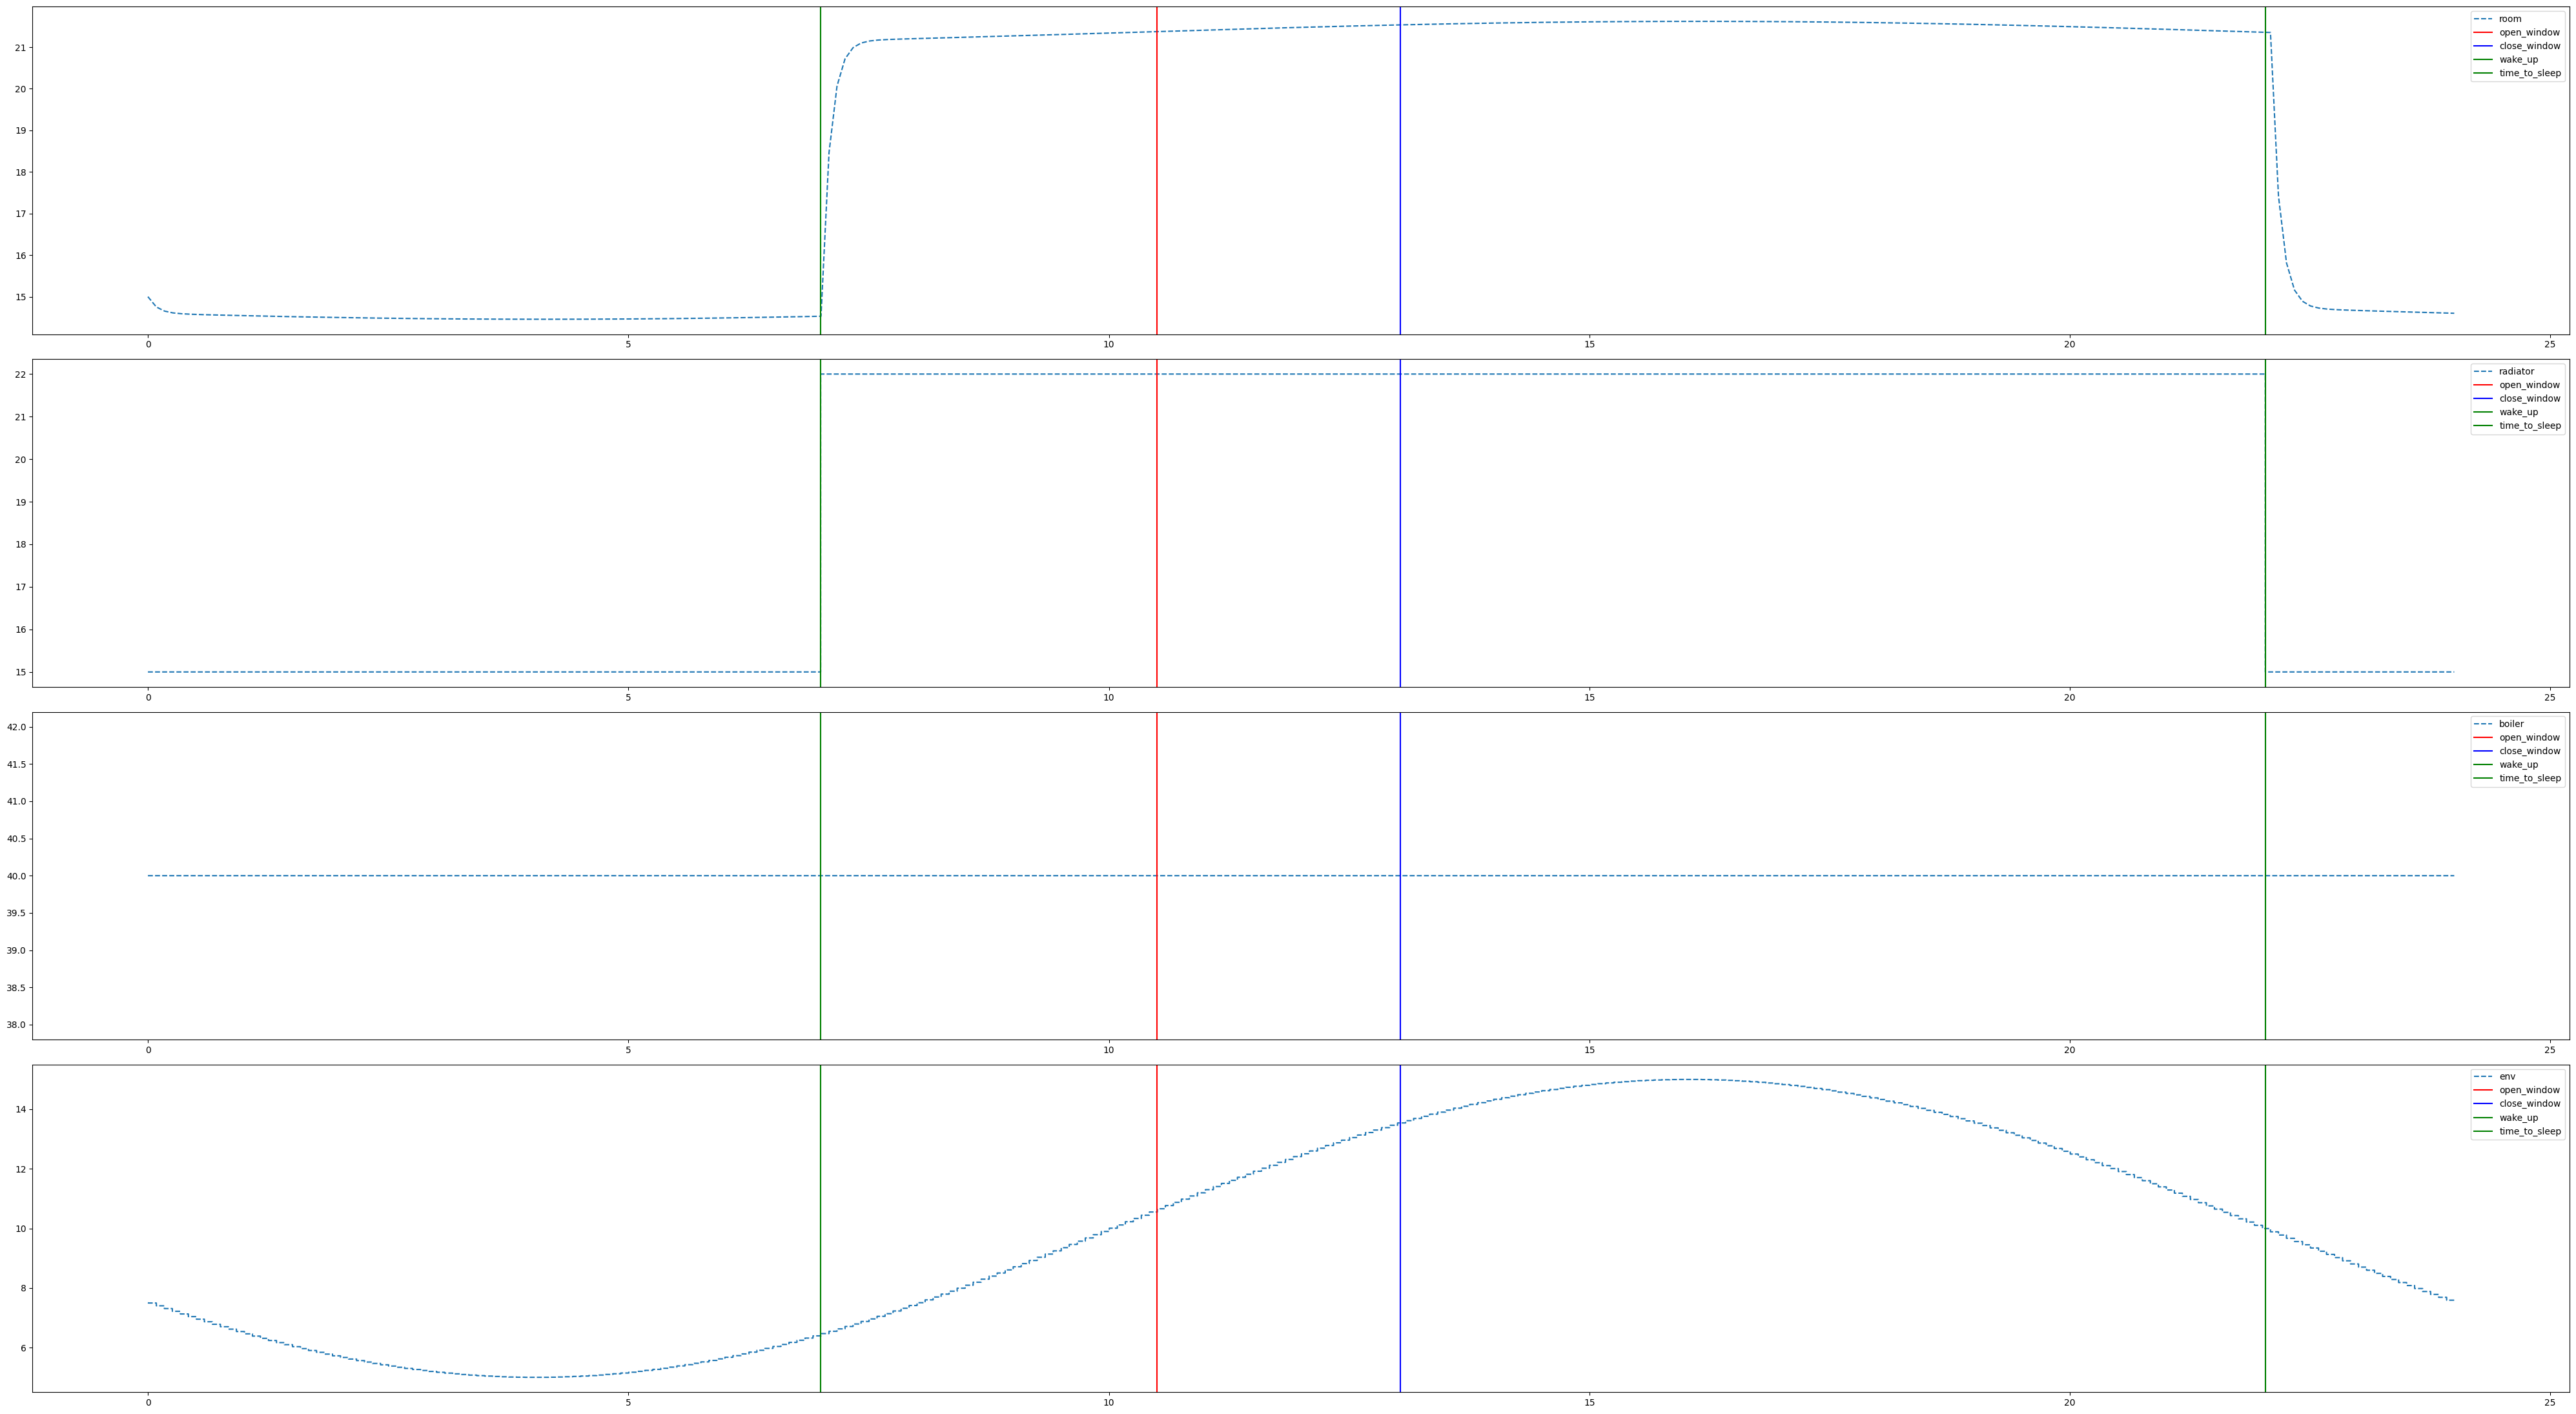

In [209]:
num = int(TimeUnits.hour) * 24
if results is not None:
    fig, ax = plt.subplots(4, 1, figsize=(40, 22))
    ax[0].plot(results['t']/3600, results['room'], '--', label='room')
    ax[1].plot(results['t']/3600, results['radiator'], '--', label='radiator')
    ax[2].plot(results['t']/3600, results['boiler'], '--', label='boiler')
    ax[3].plot(results['t']/3600, results['env'], '--', label='env')
    for _ in ax:
        plot_event(event=cw_ow_events[0], color='r', obj=_)
        plot_event(event=cw_ow_events[5], color='b', obj=_)
        plot_event(event=wake_up, color='g', obj=_)
        plot_event(event=time_to_sleep, color='g', obj=_)
        #plot_event(time_to_sleep, color='r', obj=_)
        #plot_event(per_5_hour, color='g', obj=_)
        # plot_event(close_window, color='y', obj=_)
        _.legend()        # plot_event(wake_up, color='b', obj=_)



    plt.tight_layout()
    plt.show()

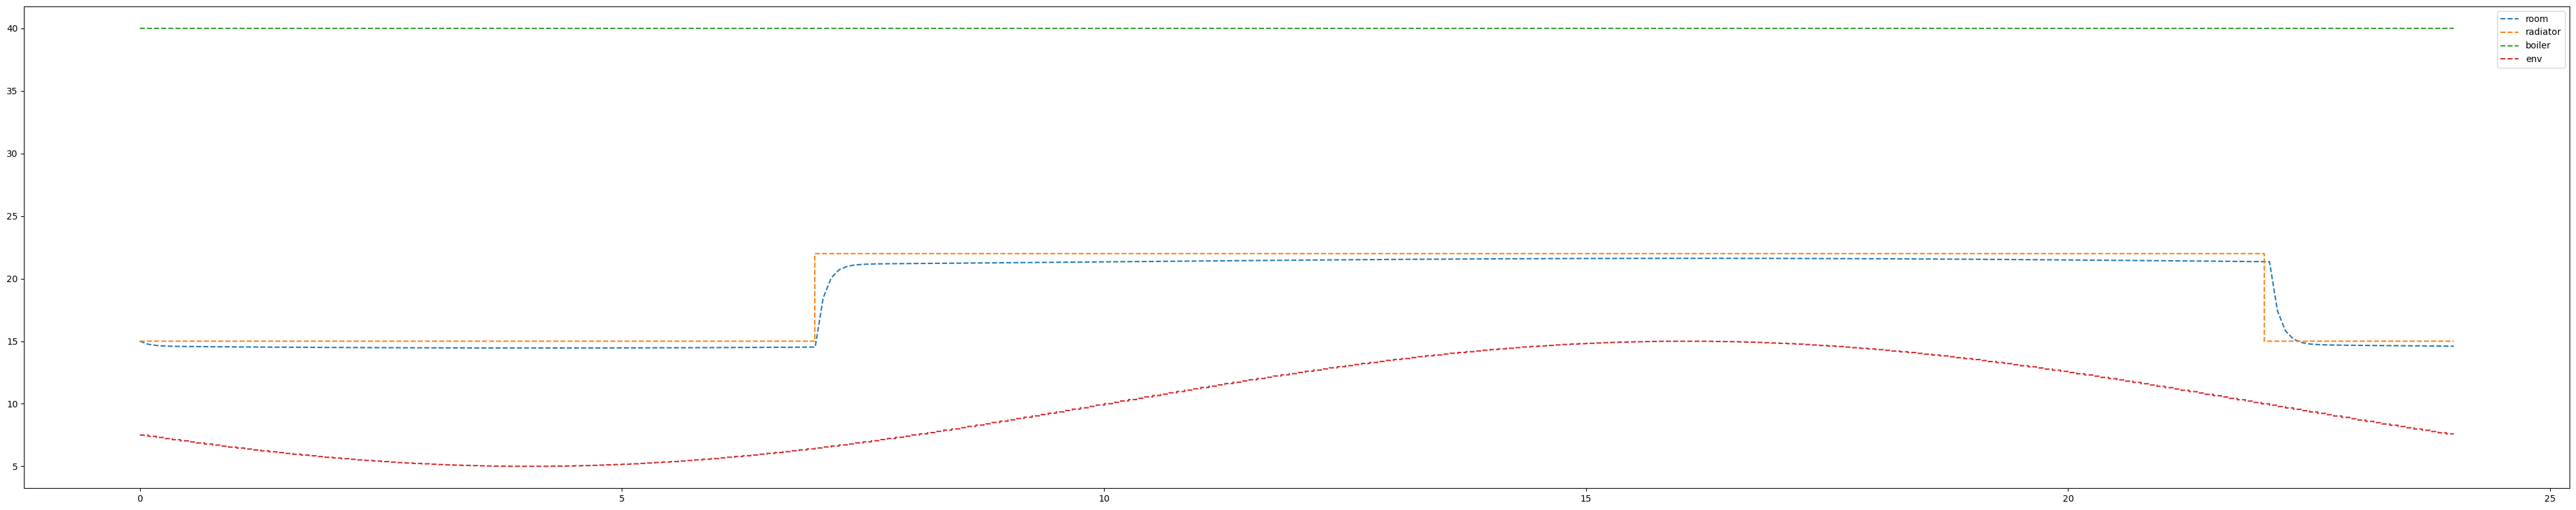

In [210]:
num = int(TimeUnits.hour) * 24
if results is not None:
    plt.figure(figsize=(40, 8))
    plt.plot(results['t']/3600, results['room'], '--', label='room')
    plt.plot(results['t']/3600, results['radiator'], '--', label='radiator')
    plt.plot(results['t']/3600, results['boiler'], '--', label='boiler')
    plt.plot(results['t']/3600, results['env'], '--', label='env')

    # plot_event(event=cw_ow_events[0], color='r', obj=plt)
    # plot_event(event=cw_ow_events[5], color='b', obj=plt)
    # plot_event(event=wake_up, color='g', obj=plt)
    # plot_event(event=time_to_sleep, color='g', obj=plt)
    #plot_event(time_to_sleep, color='r', obj=_)
    #plot_event(per_5_hour, color='g', obj=_)
    # plot_event(close_window, color='y', obj=_)
    plt.legend()        # plot_event(wake_up, color='b', obj=_)

    """for e in cw_ow_events:
        if 'open' in e.name:
            plot_event(event=e, color='b', obj=plt)
        else:
            plot_event(event=e, color='r', obj=plt)"""

    plt.tight_layout()
    plt.show()

In [211]:
import pandas as pd

In [212]:
tmp = pd.DataFrame([*zip(results['room'], results['env'], results['radiator'], results['boiler'])],
                   columns=['room', 'env', 'radiator', 'boiler'])
tmp.head()

,room,env,radiator,boiler
0,15.000000,7.5,15.0,40.0
1,14.991955,7.5,15.0,40.0
2,14.990346,7.5,15.0,40.0
3,14.988736,7.5,15.0,40.0
4,14.988415,7.5,15.0,40.0


### Gnuplot

In [213]:
data = [*zip(results['t']/3600, results['room'], results['env'], results['radiator'], results['boiler'])]
with open('tmp.dat', 'w') as f:
    for _ in data:
        f.write(('{} '*len(_)).format(*_))
        f.write('\n')

In [214]:
!gnuplot script.gp